### Imports

In [1]:
pip install utils

Note: you may need to restart the kernel to use updated packages.


In [1]:
import boto3
import pandas as pd
import os
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import importlib
import utils
import sys
from datetime import datetime
importlib.reload(utils)

<module 'utils' from '/opt/conda/lib/python3.11/site-packages/utils/__init__.py'>

### Load Data from AWS S3 Bucket

In [2]:
from src.utils import download_files_from_s3

download_files_from_s3(
    bucket_name="keithsbucketaws",
    base_key="Add_data/",
    files=["campain_add_data_taskher.csv"]
)


[INFO] Downloaded campain_add_data_taskher.csv to data/raw/campain_add_data_taskher.csv


### Read csv and save in a pandas library Data Frame

In [3]:
# Load the data into a pandas DataFrame
df = pd.read_csv('data/raw/campain_add_data_taskher.csv')

### Pre-processing
1. We begin by examining the structure of our data.

2. We can see that there are NaN values - The NaN values in Result, Result Type and Cost Per Result likely denotes that no Results were recieved, this will be encoded and communicated differently.

3. Column Names to made lowercase and addition of underscores for ease of handling casing, All string feature values are to be made lowercase with deletion of any white space.

4. How many unique Ad Set Names Exist?

5. Campaign name, Ad set name and Ad name can be parsed to produce additional features, These 3 columns can then be dropped later on as the information they represent will be available within the dataset

In [4]:
# Display the first few rows
df.head()

,Campaign name,Ad set name,Ad name,Age,Gender,Delivery status,Delivery level,Reach,Impressions,Frequency,Attribution setting,Result Type,Results,Amount spent (GBP),Cost per result,Starts,Ends,Reporting starts,Reporting ends
0,LOC|01.10|MID|PRS|QUOTE|ALL- Islington&Southwa...,ISLINGTON|ALL|18-55|COLD|Broad|IG|ALL,ISL-ELEC|IFD-STOR-RL|IMG|purple_cta_bulb,25-34,female,inactive,ad,46370,83136,1.792883,7-day click or 1-day view,quoteReceived,39.0,618.69,15.86,2024-05-09,2024-12-22,2024-04-01,2025-04-08
1,LOC|01.10|MID|PRS|QUOTE|ALL- Islington&Southwa...,SOUTHWARK|ALL|18-55|COLD|Broad|IG|ALL,STW-ELEC|IFD-STOR-RL|IMG|purple_cta_bulb,25-34,female,not_delivering,ad,48362,87271,1.804537,7-day click or 1-day view,quoteReceived,38.0,548.71,14.44,2024-05-09,2024-10-31,2024-04-01,2025-04-08
2,LOC|01.10|MID|PRS|QUOTE|ALL- Islington&Southwa...,ISLINGTON|ALL|18-55|COLD|Broad|IG|ALL,ISL-ELEC|IFD-STOR-RL|IMG|purple_cta_bulb,35-44,female,inactive,ad,24961,42207,1.690918,7-day click or 1-day view,quoteReceived,18.0,402.15,22.34,2024-05-09,2024-12-22,2024-04-01,2025-04-08
3,LDN|01.10|UPP|BAW|FAN|ALL - IGFollower,LDN|ALL|18-55|LAL|Followers&WebsiteVisitors|IG...,GEN|IFD-STOR-RL|VID|tradeplaces,25-34,female,not_delivering,ad,38045,74399,1.955553,7-day click or 1-day view,actions:visit_instagram_profile,3599.0,398.62,0.11,2024-05-08,2024-12-30,2024-04-01,2025-04-08
4,LDN|02.04|MID|RTG|QUOTE|ALL - WARM,LDN|ALL|18-45|RTG|IGFollowers&Engagers|IG|ALL,GEN|IFD-STOR-RL|VID|TradePlaces,25-34,female,inactive,ad,9102,31349,3.444188,7-day click or 1-day view,quoteReceived,36.0,347.45,9.65,2024-05-09,2025-04-30,2024-04-01,2025-04-08


Campaign name =
LOCATION | DATE | FUNNEL STAGE | GOAL | TACTIC | DESCRIPTION

Ad set name =
LOCATION | GENDER | AGE | AUDIENCE SEGMENT | AUDIENCE DETAIL | PLATFORM | PLACEMENT

Ad name =
SERVICE | AD FORMAT | ASSET TYPE | AD DESCRIPTION

In [5]:
from src.utils import process_campaign_data

df = process_campaign_data(df)


Checking for null values and drop the cost per result section

In [6]:
# Drop the 'Cost per result' column
df = df.drop(columns=['Cost per result'])


null_counts = df.isnull().sum()
print(null_counts)


Campaign name               0
Ad set name                 0
Ad name                     0
Age                         0
Gender                      0
Delivery status             0
Delivery level              0
Reach                       0
Impressions                 0
Frequency                   0
Attribution setting         0
Result Type              1143
Results                  1143
Amount spent (GBP)          0
Starts                      0
Ends                        0
Reporting starts            0
Reporting ends              0
Campaign_Location           0
Campaign_Date               0
Campaign_Funnel             0
Campaign_Goal               0
Campaign_Tactic             0
Campaign_Description        0
AdSet_Location              0
AdSet_Gender                0
AdSet_Age                   0
AdSet_AudienceSegment       0
AdSet_AudienceDetail        0
AdSet_Platform              0
AdSet_Placement            67
Ad_Service                  0
Ad_Format                   0
Ad_AssetTy

In [7]:
# --- For 'Result Type' --- 
df['Result Type'] = df['Result Type'].fillna('none').replace('', 'none')

# --- For 'Results' --- 
df['Results'] = df['Results'].fillna(0)

# Check the missing values again
null_counts_updated = df.isnull().sum()
print(null_counts_updated[['Result Type', 'Results']])

Result Type    0
Results        0
dtype: int64


In [8]:
# Clean column names: lowercase + underscores
df.columns = (
    df.columns
    .str.lower()           # Convert to lowercase
    .str.replace(r'([a-z])([A-Z])', r'\1_\2', regex=True)  # Add underscore between camelCase
    .str.replace(r'[ \-]+', '_', regex=True)  # Replace spaces/hyphens with underscores
)

print(df.columns)

Index(['campaign_name', 'ad_set_name', 'ad_name', 'age', 'gender',
       'delivery_status', 'delivery_level', 'reach', 'impressions',
       'frequency', 'attribution_setting', 'result_type', 'results',
       'amount_spent_(gbp)', 'starts', 'ends', 'reporting_starts',
       'reporting_ends', 'campaign_location', 'campaign_date',
       'campaign_funnel', 'campaign_goal', 'campaign_tactic',
       'campaign_description', 'adset_location', 'adset_gender', 'adset_age',
       'adset_audiencesegment', 'adset_audiencedetail', 'adset_platform',
       'adset_placement', 'ad_service', 'ad_format', 'ad_assettype',
       'ad_description'],
      dtype='object')


In [9]:
from src.utils import clean_string

# Apply to all string columns
string_cols = df.select_dtypes(include=['object']).columns
df[string_cols] = df[string_cols].applymap(clean_string)

print(df)

                                          campaign_name  \
0     loc|01.10|mid|prs|quote|all-islington&southwar...   
1     loc|01.10|mid|prs|quote|all-islington&southwar...   
2     loc|01.10|mid|prs|quote|all-islington&southwar...   
3                  ldn|01.10|upp|baw|fan|all-igfollower   
4                      ldn|02.04|mid|rtg|quote|all-warm   
...                                                 ...   
3845               ldn|01.10|upp|baw|fan|all-igfollower   
3846               ldn|01.10|upp|baw|fan|all-igfollower   
3847               ldn|01.10|upp|baw|fan|all-igfollower   
3852               ldn|01.10|upp|baw|fan|all-igfollower   
3853               ldn|01.10|upp|baw|fan|all-igfollower   

                                            ad_set_name  \
0                 islington|all|18-55|cold|broad|ig|all   
1                 southwark|all|18-55|cold|broad|ig|all   
2                 islington|all|18-55|cold|broad|ig|all   
3     ldn|all|18-55|lal|followers&websitevisitors|ig...

/tmp/ipykernel_6453/401278575.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[string_cols] = df[string_cols].applymap(clean_string)


In [10]:
df = df.drop(columns=['campaign_name'])
df = df.drop(columns=['ad_set_name'])
df = df.drop(columns=['ad_name'])

### Encoding String Values

In [11]:
from src.utils import count_unique_string_values

unique_counts = count_unique_string_values(df)


Column: age
Unique values: 7
Value frequencies:
age
25-34      317
35-44      305
18-24      303
45-54      260
55-64      205
65+        172
unknown      2
Name: count, dtype: int64

Column: gender
Unique values: 3
Value frequencies:
gender
female     667
male       481
unknown    416
Name: count, dtype: int64

Column: delivery_status
Unique values: 3
Value frequencies:
delivery_status
not_delivering    901
inactive          609
active             54
Name: count, dtype: int64

Column: delivery_level
Unique values: 1
Value frequencies:
delivery_level
ad    1564
Name: count, dtype: int64

Column: attribution_setting
Unique values: 1
Value frequencies:
attribution_setting
7-dayclickor1-dayview    1564
Name: count, dtype: int64

Column: result_type
Unique values: 5
Value frequencies:
result_type
none                               1143
quotereceived                       214
actions:visit_instagram_profile     129
linkclicks                           45
metaleads                          

In [12]:
df.head()

,age,gender,delivery_status,delivery_level,reach,impressions,frequency,attribution_setting,result_type,results,...,adset_gender,adset_age,adset_audiencesegment,adset_audiencedetail,adset_platform,adset_placement,ad_service,ad_format,ad_assettype,ad_description
0,25-34,female,inactive,ad,46370,83136,1.792883,7-dayclickor1-dayview,quotereceived,39.0,...,all,18-55,cold,broad,ig,all,isl-elec,ifd-stor-rl,img,purple_cta_bulb
1,25-34,female,not_delivering,ad,48362,87271,1.804537,7-dayclickor1-dayview,quotereceived,38.0,...,all,18-55,cold,broad,ig,all,stw-elec,ifd-stor-rl,img,purple_cta_bulb
2,35-44,female,inactive,ad,24961,42207,1.690918,7-dayclickor1-dayview,quotereceived,18.0,...,all,18-55,cold,broad,ig,all,isl-elec,ifd-stor-rl,img,purple_cta_bulb
3,25-34,female,not_delivering,ad,38045,74399,1.955553,7-dayclickor1-dayview,actions:visit_instagram_profile,3599.0,...,all,18-55,lal,followers&websitevisitors,ig,all,gen,ifd-stor-rl,vid,tradeplaces
4,25-34,female,inactive,ad,9102,31349,3.444188,7-dayclickor1-dayview,quotereceived,36.0,...,all,18-45,rtg,igfollowers&engagers,ig,all,gen,ifd-stor-rl,vid,tradeplaces


In [13]:
unique_counts

{'age': 7,
 'gender': 3,
 'delivery_status': 3,
 'delivery_level': 1,
 'attribution_setting': 1,
 'result_type': 5,
 'starts': 7,
 'ends': 6,
 'reporting_starts': 1,
 'reporting_ends': 1,
 'campaign_location': 2,
 'campaign_date': 6,
 'campaign_funnel': 2,
 'campaign_goal': 4,
 'campaign_tactic': 4,
 'campaign_description': 7,
 'adset_location': 4,
 'adset_gender': 1,
 'adset_age': 3,
 'adset_audiencesegment': 6,
 'adset_audiencedetail': 9,
 'adset_platform': 2,
 'adset_placement': 3,
 'ad_service': 19,
 'ad_format': 1,
 'ad_assettype': 2,
 'ad_description': 36}

In [15]:
from src.utils import analyze_non_string_features

# Usage
analyze_non_string_features(df)

Found 5 non-string features:
Column: reach
Type: int64
Unique values: 496
Sample values: [46370 48362 24961 38045  9102]
Missing values: 0 (0.0%)
Min: 0
Max: 48362
Mean: 681.47
Median: 30.00
--------------------------------------------------
Column: impressions
Type: int64
Unique values: 609
Sample values: [83136 87271 42207 74399 31349]
Missing values: 0 (0.0%)
Min: 0
Max: 87271
Mean: 1262.91
Median: 42.00
--------------------------------------------------
Column: frequency
Type: float64
Unique values: 797
Sample values: [1.79288333 1.80453662 1.69091783 1.95555264 3.44418809]
Missing values: 0 (0.0%)
Min: 0.0
Max: 7.0
Mean: 1.45
Median: 1.20
--------------------------------------------------
Column: results
Type: float64
Unique values: 88
Sample values: [  39.   38.   18. 3599.   36.]
Missing values: 0 (0.0%)
Min: 0.0
Max: 3599.0
Mean: 13.76
Median: 0.00
--------------------------------------------------
Column: amount_spent_(gbp)
Type: float64
Unique values: 614
Sample values: [618.

In [16]:
from src.utils import encode_categorical_fast

mapping_dir='data/encoded_data'

# Usage example:
encoded_df, mappings = encode_categorical_fast(df,mapping_dir)

In [17]:
encoded_df.head()

,age,gender,delivery_status,reach,impressions,frequency,result_type,results,amount_spent_(gbp),starts,...,campaign_description,adset_location,adset_age,adset_audiencesegment,adset_audiencedetail,adset_platform,adset_placement,ad_service,ad_assettype,ad_description
0,1,0,1,46370,83136,1.792883,4,39.0,618.69,1,...,4,1,1,1,0,1,0,0.023018,0,0.042839
1,1,0,2,48362,87271,1.804537,4,38.0,548.71,1,...,4,3,1,1,0,1,0,0.021739,0,0.042839
2,2,0,1,24961,42207,1.690918,4,18.0,402.15,1,...,4,1,1,1,0,1,0,0.023018,0,0.042839
3,1,0,2,38045,74399,1.955553,0,3599.0,398.62,0,...,3,2,1,3,1,1,0,0.441816,1,0.072890
4,1,0,1,9102,31349,3.444188,4,36.0,347.45,1,...,5,2,0,4,4,1,0,0.441816,1,0.072890


### Download the encoded dataset along with the encoding mappings 

In [18]:
encoded_df.to_csv(f'data/encoded_data/encoded_df.csv')

In [19]:
encoded_df.shape

(1564, 26)

In [20]:
# Print detailed column information
print("DataFrame Columns Overview:")
print("=" * 50)
for i, col in enumerate(df.columns, 1):
    print(f"{i}. {col}")
    print(f"   Type: {df[col].dtype}")
    print(f"   Unique values: {df[col].nunique()}")
    print(f"   Sample values: {df[col].dropna().unique()[:3]}")
    print("-" * 50)

DataFrame Columns Overview:
1. age
   Type: int64
   Unique values: 7
   Sample values: [1 2 0]
--------------------------------------------------
2. gender
   Type: int64
   Unique values: 3
   Sample values: [0 1 2]
--------------------------------------------------
3. delivery_status
   Type: int64
   Unique values: 3
   Sample values: [1 2 0]
--------------------------------------------------
4. reach
   Type: int64
   Unique values: 496
   Sample values: [46370 48362 24961]
--------------------------------------------------
5. impressions
   Type: int64
   Unique values: 609
   Sample values: [83136 87271 42207]
--------------------------------------------------
6. frequency
   Type: float64
   Unique values: 797
   Sample values: [1.79288333 1.80453662 1.69091783]
--------------------------------------------------
7. result_type
   Type: int64
   Unique values: 5
   Sample values: [4 0 2]
--------------------------------------------------
8. results
   Type: float64
   Unique val

### ANALYSIS FOR POOJ
1. Cheapest Asset Type (Image vs Video) (Adpted to be used by new datasets)

In [22]:
from src.utils import decode_categorical_fast

# Decode the dataframe first
decoded_df = decode_categorical_fast(encoded_df,mapping_dir)

# Now analyze using decoded values
cost_per_quote = (decoded_df.groupby('ad_assettype')['amount_spent_(gbp)'].sum() / 
                 decoded_df.groupby('ad_assettype')['results'].sum())

print("Cost per quote by asset type:")
print(cost_per_quote.sort_values())

Cost per quote by asset type:
ad_assettype
vid     0.435946
img    11.185380
dtype: float64


2. Cheapest Service Area (Adpted to be used by new datasets)

In [23]:
service_cost = (decoded_df.groupby('ad_service')['amount_spent_(gbp)'].sum() / 
               decoded_df.groupby('ad_service')['results'].sum())

print("\nCost per quote by service:")
print(service_cost.sort_values())


Cost per quote by service:
ad_service
gen           0.432923
crowd         1.427706
ugc           1.735695
elec          8.502187
hack-plum    11.065833
isl-plum     12.699556
stw-plum     12.715385
plum         13.128000
hack-elec    13.670656
isl-gas      18.550000
hack-gas     23.770000
isl-boil     27.840000
hack-boil    64.520000
dtype: float64


3. Age and Gender Insights (Adpted to be used by new datasets)

In [24]:
# Age analysis (now uses decoded labels directly)
age_quotes = decoded_df.groupby('age')['results'].sum().sort_values(ascending=False)

print("\nQuotes by age group:")
print(age_quotes)

# Gender analysis (uses decoded labels directly)
gender_quotes = decoded_df.groupby('gender')['results'].sum()
gender_cost = (decoded_df.groupby('gender')['amount_spent_(gbp)'].sum() / 
              decoded_df.groupby('gender')['results'].sum())

print("\nQuotes by gender:")
print(gender_quotes)
print("\nCost per quote by gender:")
print(gender_cost)

# Bonus: Add formatted output
def format_analysis(series, title):
    print(f"\n{title}:")
    if series.dtype == 'float64':
        print(series.sort_values().apply(lambda x: f"£{x:.2f}"))
    else:
        print(series.sort_values(ascending=False))

format_analysis(age_quotes, "Quotes by age group (formatted)")
format_analysis(gender_quotes, "Quotes by gender (formatted)")
format_analysis(gender_cost, "Cost per quote by gender (formatted)")


Quotes by age group:
age
25-34      9811.0
18-24      8286.0
35-44      2391.0
45-54       603.0
55-64       269.0
65+         136.0
unknown      19.0
Name: results, dtype: float64

Quotes by gender:
gender
female     13375.0
male        6323.0
unknown     1817.0
Name: results, dtype: float64

Cost per quote by gender:
gender
female     1.075779
male       0.339344
unknown    0.416483
dtype: float64

Quotes by age group (formatted):
age
unknown      £19.00
65+         £136.00
55-64       £269.00
45-54       £603.00
35-44      £2391.00
18-24      £8286.00
25-34      £9811.00
Name: results, dtype: object

Quotes by gender (formatted):
gender
unknown     £1817.00
male        £6323.00
female     £13375.00
Name: results, dtype: object

Cost per quote by gender (formatted):
gender
male       £0.34
unknown    £0.42
female     £1.08
dtype: object


4. Monthly Quote Prediction (£30/day budget)

In [27]:
# Redirect print output to a file
original_stdout = sys.stdout  # Save original stdout
df = encoded_df
with open('reports/scripts', 'w') as f:
    sys.stdout = f  # Change stdout to file
    
    # Print report header
    print("="*60)
    print(" AD PERFORMANCE ANALYSIS REPORT".center(60))
    print(f"Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}".center(60))
    print("="*60)
    
    # 1. Age Analysis
    print("\n\n" + " AGE GROUP PERFORMANCE ".center(60, '-'))
    age_quotes = df.groupby('age')['results'].sum().sort_values(ascending=False)
    age_quotes.index = age_quotes.index.map(age_map)
    print("\nQuotes by age group:")
    print(age_quotes.to_string())
    
    # 2. Gender Analysis
    print("\n\n" + " GENDER PERFORMANCE ".center(60, '-'))
    gender_quotes = df.groupby('gender')['results'].sum()
    gender_cost = (df.groupby('gender')['amount_spent_(gbp)'].sum() / 
                  df.groupby('gender')['results'].sum())
    print("\nQuotes by gender:")
    print(gender_quotes.rename(gender_map).to_string())
    print("\nCost per quote by gender:")
    print(gender_cost.rename(gender_map).to_string())
    
    # 3. Service Analysis
    print("\n\n" + " SERVICE PERFORMANCE ".center(60, '-'))
    service_cost = (df.groupby('ad_service')['amount_spent_(gbp)'].sum() / 
                   df.groupby('ad_service')['results'].sum())
    service_cost.index = service_cost.index.map(reverse_service_map)
    print("\nCost per quote by service:")
    print(service_cost.sort_values().to_string())
    
    # 4. Efficiency Metrics
    print("\n\n" + " EFFICIENCY METRICS ".center(60, '-'))
    print(f"\nTotal Amount Spent: £{total_spent:,.2f}")
    print(f"Total Quotes Received: {total_quotes:,.0f}")
    print(f"\nCurrent Cost Per Quote (CPQ): £{current_cpq:.2f}")
    print(f"Quotes per £100 spent: {(total_quotes/total_spent)*100:.1f}")
    print(f"\nPredicted Monthly Quotes @ £30/day: {predicted_quotes:,.0f}")
    
    print("\n\n" + " END OF REPORT ".center(60, '='))
    
    sys.stdout = original_stdout  # Reset stdout

print("Analysis report saved to 'ad_analysis_report.txt'")

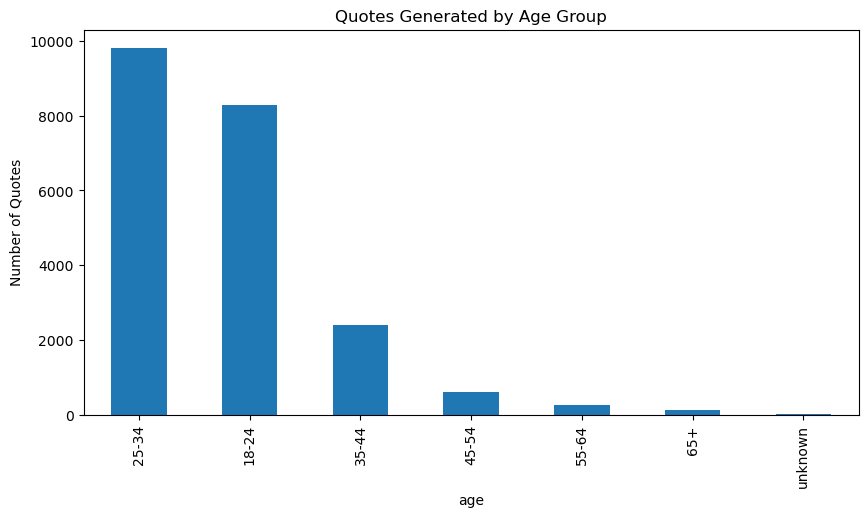

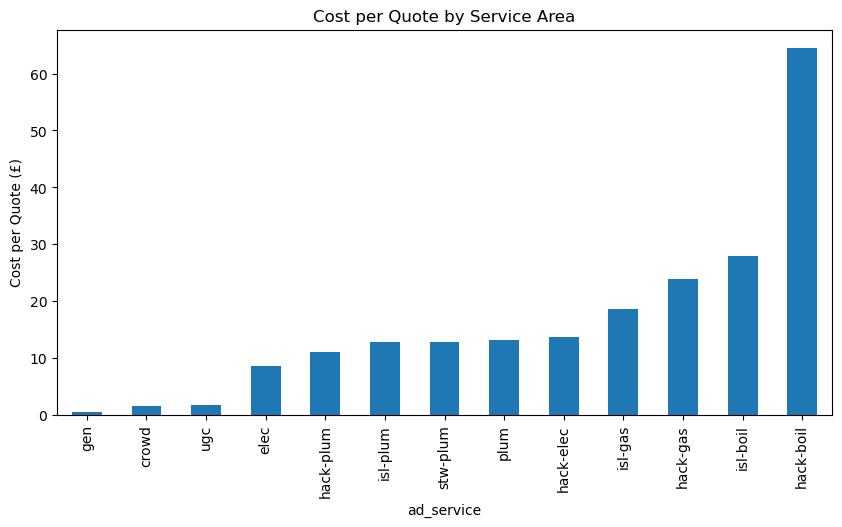

In [44]:
import matplotlib.pyplot as plt

# Visualize age performance
plt.figure(figsize=(10,5))
age_quotes.plot(kind='bar')
plt.title('Quotes Generated by Age Group')
plt.ylabel('Number of Quotes')
plt.show()

# Visualize service efficiency
plt.figure(figsize=(10,5))
service_cost.sort_values().plot(kind='bar')
plt.title('Cost per Quote by Service Area')
plt.ylabel('Cost per Quote (£)')
plt.show()